In [54]:
import lsst.meas.astrom as measAstrom
import lsst.daf.base as dafBase
import lsst.pipe.base as pipeBase
import lsst.daf.persistence as dafPersist

import random
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.display.ds9 as ds9
import lsst.afw.table as afwTable

import DiaSourceTools as DSTools
import lsst.afw.display.utils as displayUtils
import lsst.meas.algorithms.detection as sDet

%matplotlib inline

In [212]:
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")

subset = butler.subset("deepDiff_diaSrc")
#file = open("diaSources.txt", "w")
diaSourcesList = []
for dr_subSet in subset:
    if dr_subSet.dataId["ccd"]==14:
        #file.write("visit="+str(dr_subSet.dataId["visit"])+"\n")
        try:
            diaSourcesList.append(dr_subSet)
           
        except:
            pass

In [213]:
visit = 850180

dataId = {'visit': visit , 'filter':'r' , 'ccd':14}
diaSrcs = butler.get("deepDiff_diaSrc", dataId)
diffExp = butler.get("deepDiff_differenceExp", dataId)
sciExp  = butler.get("calexp", dataId)
tmpExp = butler.get("deepDiff_warpedExp", dataId)
bgConf = sDet.BackgroundConfig()
background,tmpExp = sDet.estimateBackground(tmpExp,bgConf,True)

In [214]:
fluxes, sigmas = DSTools.get_fluxes_and_sigmas(diaSrcs, "base_PeakLikelihoodFlux_flux")

m_sigma = np.mean(sigmas)
t_sigma = 5*m_sigma

sources = DSTools.get_sources_over_sigma(diaSrcs, t_sigma, "base_PeakLikelihoodFlux_flux")

In [215]:
mosaic_dif = displayUtils.Mosaic(gutter=3, background=3, mode="square")
mosaic_sci = displayUtils.Mosaic(gutter=3, background=3, mode="square")
mosaic_tmp = displayUtils.Mosaic(gutter=3, background=3, mode="square")

for i, source in enumerate(sources):
    try:
        dif_stamp = DSTools.get_stamp(source, diffExp)
        
        negFlux   = np.abs(source.get("ip_diffim_PsfDipoleFlux_neg_flux"))
        posFlux   = np.abs(source.get("ip_diffim_PsfDipoleFlux_pos_flux"))
        totalFlux=negFlux+posFlux
        passesFluxNeg = (negFlux / totalFlux)
        passesFluxPos = (posFlux / totalFlux)
        
        mosaic_dif.append(dif_stamp.getMaskedImage(), label=str(i)+"-"+str(source.get("classification_dipole")))
        
        sci_stamp = DSTools.get_stamp(source, sciExp)
        mosaic_sci.append(sci_stamp.getMaskedImage(), label=str(i))

        
        tmp_stamp = DSTools.get_stamp(source, tmpExp)
        mosaic_tmp.append(tmp_stamp.getMaskedImage(), label=str(i))
    except Exception, e:
        print e


  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::afw::geom::Extent2I = lsst::afw::geom::Extent<int, 2>]
    Box2I(Point2I(983,0),Extent2I(1068,1091)) doesn't fit in image 2048x4612 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(983,0),Extent2I(1068,1091)) doesn't fit in image 2048x4612'


  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_vie

In [59]:
mosaic_dif.makeMosaic(frame=1, title="mosaic_dif")
ds9.setMaskTransparency(100, frame=1)
mosaic_sci.makeMosaic(frame=2, title="mosaic_science")
ds9.setMaskTransparency(100, frame=2)
mosaic_tmp.makeMosaic(frame=3, title="mosaic_template")
ds9.setMaskTransparency(100, frame=3)

ds9 doesn't appear to be running (XPA: XPA returned NULL, (;iconify no; raise)), I'll try to exec it for you


In [60]:
ds9.mtv(diffExp, frame=4)

for i, s in enumerate(sources):
    ds9.dot(i, s.getX()-1, s.getY()-1, frame=4)

In [209]:
reload(DSTools)

<module 'DiaSourceTools' from 'DiaSourceTools.py'>

===========Source # 0==============
negative lobe
0.256944444444 36
75% of sources contribute 97.0484265801% of total flux
50% of sources contribute 88.7756539955% of total flux
25% of sources contribute 72.1715755726% of total flux
10% of sources contribute 50.2246685147% of total flux


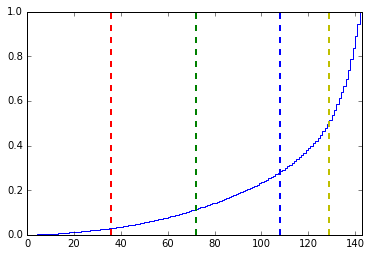

positive lobe
0.257352941176 34
75% of sources contribute 97.4466562181% of total flux
50% of sources contribute 88.7580835484% of total flux
25% of sources contribute 69.9385214458% of total flux
10% of sources contribute 44.350378934% of total flux


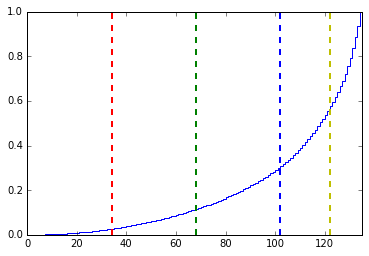

===========Source # 1==============
negative lobe
0.251677852349 74
75% of sources contribute 94.640249843% of total flux
50% of sources contribute 78.6787373714% of total flux
25% of sources contribute 51.3895485874% of total flux
10% of sources contribute 27.7389435087% of total flux


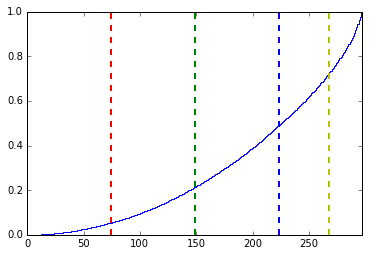

positive lobe
No values for mask DETECTED
===========Source # 2==============
negative lobe
0.250807319699 232
75% of sources contribute 99.1610991466% of total flux
50% of sources contribute 96.6300472923% of total flux
25% of sources contribute 92.1078627396% of total flux
10% of sources contribute 87.5774512246% of total flux


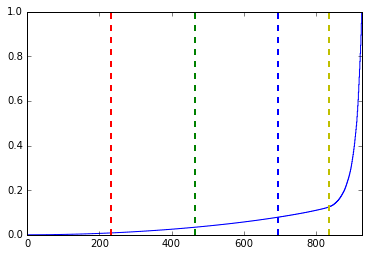

positive lobe
0.250652741514 383
75% of sources contribute 99.6232855508% of total flux
50% of sources contribute 98.57213665% of total flux
25% of sources contribute 96.2727536509% of total flux
10% of sources contribute 90.345058062% of total flux


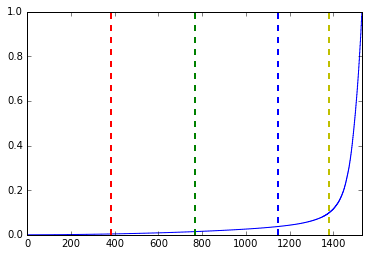

===========Source # 3==============
negative lobe
0.25016903313 369
75% of sources contribute 94.4416807775% of total flux
50% of sources contribute 77.6573553827% of total flux
25% of sources contribute 49.0775823134% of total flux
10% of sources contribute 23.7472186478% of total flux


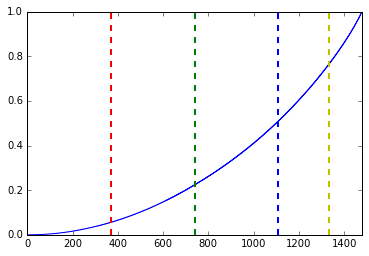

positive lobe
0.250203086921 923
75% of sources contribute 99.4827308383% of total flux
50% of sources contribute 97.8860546222% of total flux
25% of sources contribute 93.9334226454% of total flux
10% of sources contribute 82.8912899642% of total flux


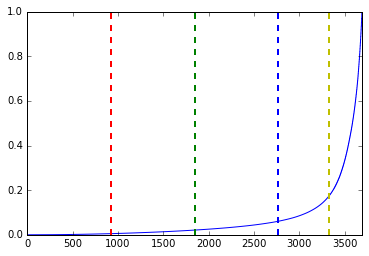

===========Source # 4==============

  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::afw::geom::Extent2I = lsst::afw::geom::Extent<int, 2>]
    Box2I(Point2I(983,0),Extent2I(1068,1091)) doesn't fit in image 2048x4612 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(983,0),Extent2I(1068,1091)) doesn't fit in image 2048x4612'

===========Source # 5==============
negative lobe
0.256637168142 28
75% of sources contribute 93.8877848213% of total flux
50% of sources contribute 77.3404098478% of total flux
25% of sources contribute 48.8783162503% of total flux
10% of sources 

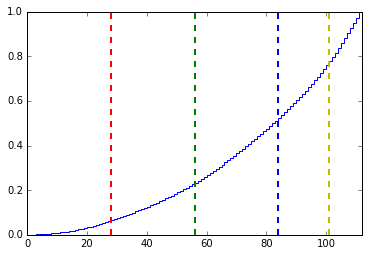

positive lobe
0.250133523233 1404
75% of sources contribute 99.2155008629% of total flux
50% of sources contribute 96.8891335419% of total flux
25% of sources contribute 92.3932645788% of total flux
10% of sources contribute 85.1134847165% of total flux


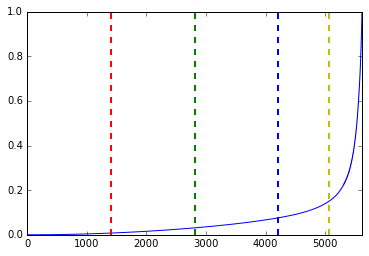

===========Source # 6==============
negative lobe
0.269230769231 13
75% of sources contribute 96.5329101521% of total flux
50% of sources contribute 89.5869568315% of total flux
25% of sources contribute 62.5710823849% of total flux
10% of sources contribute 34.5111013872% of total flux


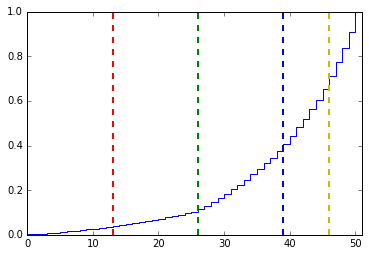

positive lobe
0.250142938822 874
75% of sources contribute 99.2816859815% of total flux
50% of sources contribute 97.2382594584% of total flux
25% of sources contribute 93.1716321795% of total flux
10% of sources contribute 86.1077548801% of total flux


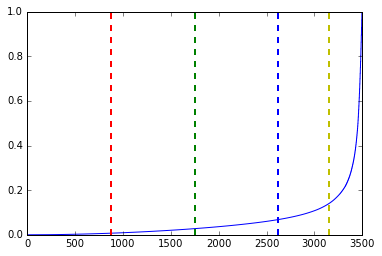

===========Source # 7==============
negative lobe
0.253623188406 34
75% of sources contribute 96.097340758% of total flux
50% of sources contribute 86.1582744445% of total flux
25% of sources contribute 67.0027584542% of total flux
10% of sources contribute 43.8209820212% of total flux


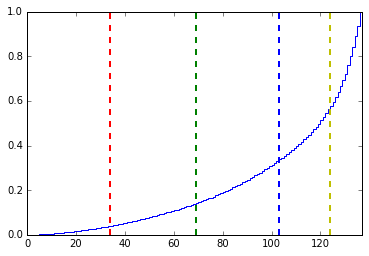

positive lobe
No values for mask DETECTED
===========Source # 8==============
negative lobe
0.254098360656 30
75% of sources contribute 95.1357749525% of total flux
50% of sources contribute 81.697957735% of total flux
25% of sources contribute 57.740730663% of total flux
10% of sources contribute 33.526750733% of total flux


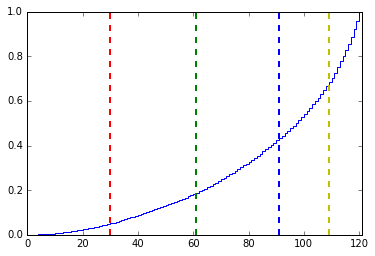

positive lobe
No values for mask DETECTED
===========Source # 9==============
negative lobe
0.254032258065 62
75% of sources contribute 94.1207716202% of total flux
50% of sources contribute 77.6359301899% of total flux
25% of sources contribute 48.0344269605% of total flux
10% of sources contribute 22.6886072078% of total flux


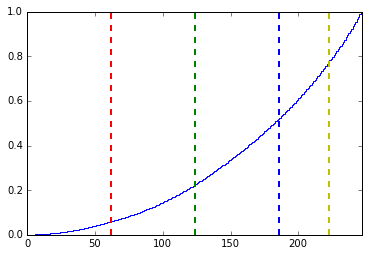

positive lobe
0.25011096316 1126
75% of sources contribute 99.2083219961% of total flux
50% of sources contribute 96.932546725% of total flux
25% of sources contribute 92.286332478% of total flux
10% of sources contribute 84.0289160064% of total flux


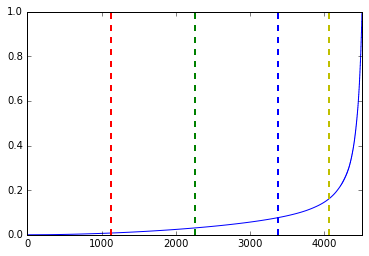

===========Source # 10==============
negative lobe
0.25641025641 19
75% of sources contribute 92.5540724439% of total flux
50% of sources contribute 74.3646641537% of total flux
25% of sources contribute 47.476879364% of total flux
10% of sources contribute 21.2111239599% of total flux


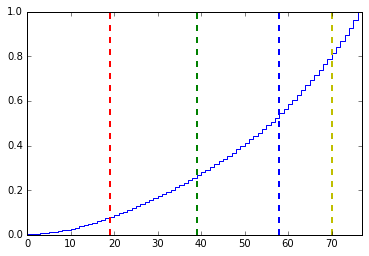

positive lobe
0.255319148936 11
75% of sources contribute 97.5707065249% of total flux
50% of sources contribute 88.0302706658% of total flux
25% of sources contribute 69.3516151318% of total flux
10% of sources contribute 50.8619814911% of total flux


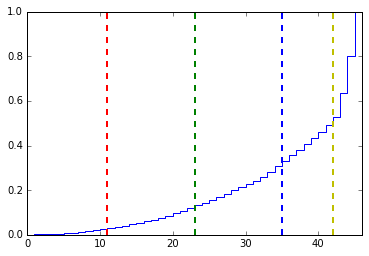

===========Source # 11==============
negative lobe
0.257142857143 26
75% of sources contribute 93.2867298316% of total flux
50% of sources contribute 78.5985207376% of total flux
25% of sources contribute 54.7885974332% of total flux
10% of sources contribute 29.1961777882% of total flux


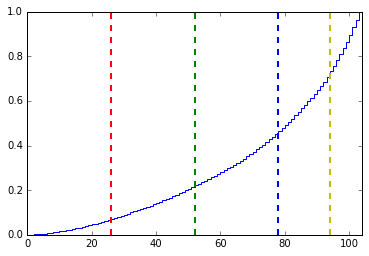

positive lobe
No values for mask DETECTED
===========Source # 12==============
negative lobe
No values for mask DETECTED_NEGATIVE
positive lobe
0.250064985703 1923
75% of sources contribute 99.0975667381% of total flux
50% of sources contribute 96.5523368635% of total flux
25% of sources contribute 91.7665426497% of total flux
10% of sources contribute 84.7615557801% of total flux


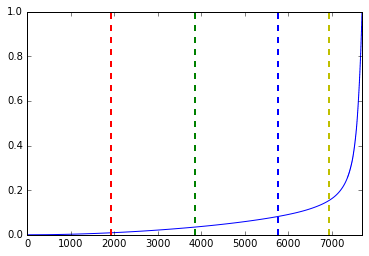

===========Source # 13==============
negative lobe
0.258620689655 14
75% of sources contribute 96.2104826336% of total flux
50% of sources contribute 84.7772609189% of total flux
25% of sources contribute 66.8540184835% of total flux
10% of sources contribute 49.8226937804% of total flux


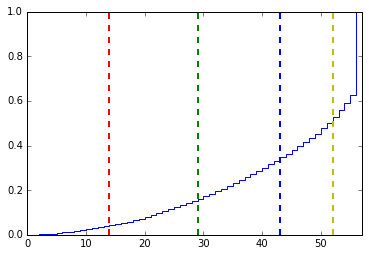

positive lobe
No values for mask DETECTED
===========Source # 14==============

  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::afw::geom::Extent2I = lsst::afw::geom::Extent<int, 2>]
    Box2I(Point2I(1801,2231),Extent2I(250,404)) doesn't fit in image 2048x4612 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(1801,2231),Extent2I(250,404)) doesn't fit in image 2048x4612'

===========Source # 15==============
negative lobe
0.257142857143 35
75% of sources contribute 96.5335048236% of total flux
50% of sources contribute 85.0276896961% of total flux
25% of sources contrib

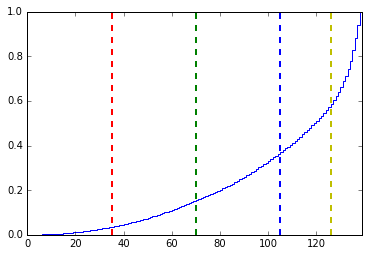

positive lobe
No values for mask DETECTED
===========Source # 16==============
negative lobe
0.258620689655 14
75% of sources contribute 95.6437880002% of total flux
50% of sources contribute 82.7465407796% of total flux
25% of sources contribute 59.8678475547% of total flux
10% of sources contribute 33.0961498388% of total flux


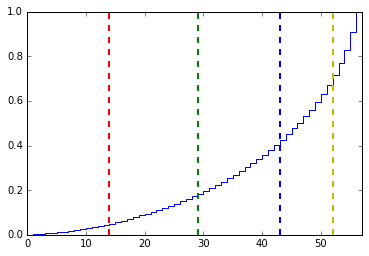

positive lobe
No values for mask DETECTED
===========Source # 17==============
negative lobe
0.251497005988 41
75% of sources contribute 98.6248921736% of total flux
50% of sources contribute 94.2510753955% of total flux
25% of sources contribute 83.3161898916% of total flux
10% of sources contribute 60.2103204123% of total flux


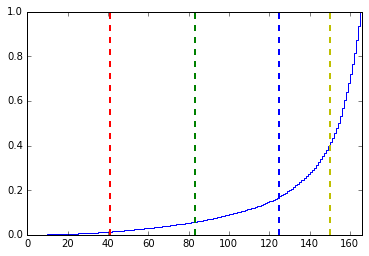

positive lobe
0.254237288136 44
75% of sources contribute 98.0922626709% of total flux
50% of sources contribute 92.3431057302% of total flux
25% of sources contribute 81.204943938% of total flux
10% of sources contribute 60.1651591327% of total flux


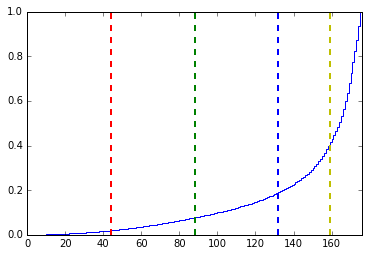

===========Source # 18==============
negative lobe
No values for mask DETECTED_NEGATIVE
positive lobe
0.253521126761 17
75% of sources contribute 96.8541468404% of total flux
50% of sources contribute 84.5272580149% of total flux
25% of sources contribute 58.0358705414% of total flux
10% of sources contribute 38.9144986859% of total flux


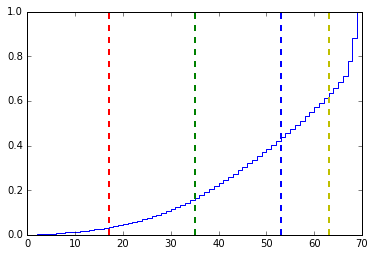

===========Source # 19==============
negative lobe
0.263157894737 14
75% of sources contribute 95.7335212776% of total flux
50% of sources contribute 80.4081460678% of total flux
25% of sources contribute 55.266637854% of total flux
10% of sources contribute 30.7263288894% of total flux


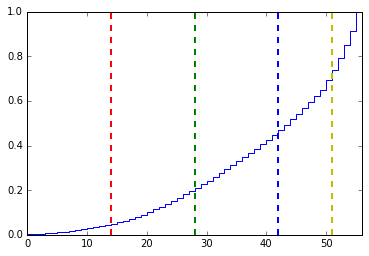

positive lobe
No values for mask DETECTED
===========Source # 20==============
negative lobe
0.265625 16
75% of sources contribute 94.1977937837% of total flux
50% of sources contribute 81.0226694476% of total flux
25% of sources contribute 55.8248362271% of total flux
10% of sources contribute 29.9251326606% of total flux


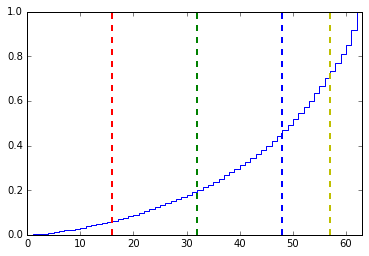

positive lobe
No values for mask DETECTED
===========Source # 21==============
negative lobe
0.256198347107 30
75% of sources contribute 97.0642433682% of total flux
50% of sources contribute 89.3717777512% of total flux
25% of sources contribute 71.9248665342% of total flux
10% of sources contribute 42.7366644414% of total flux


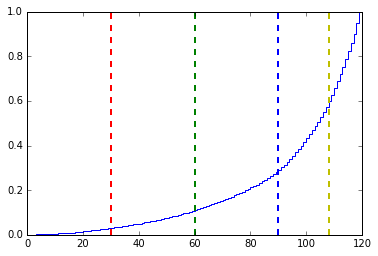

positive lobe
0.251851851852 33
75% of sources contribute 98.0102839227% of total flux
50% of sources contribute 90.8410725546% of total flux
25% of sources contribute 73.3890526607% of total flux
10% of sources contribute 46.31925882% of total flux


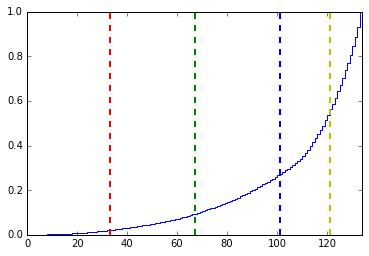

===========Source # 22==============
negative lobe
No values for mask DETECTED_NEGATIVE
positive lobe
0.250896057348 69
75% of sources contribute 96.0468260432% of total flux
50% of sources contribute 84.9760768494% of total flux
25% of sources contribute 63.7168705695% of total flux
10% of sources contribute 40.5412185678% of total flux


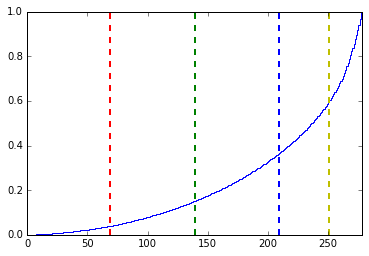

===========Source # 23==============
negative lobe
0.265625 16
75% of sources contribute 95.6417575963% of total flux
50% of sources contribute 83.7021461301% of total flux
25% of sources contribute 62.7813439269% of total flux
10% of sources contribute 37.5793118049% of total flux


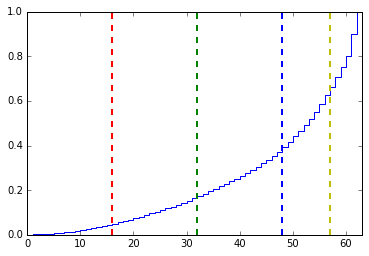

positive lobe
No values for mask DETECTED
===========Source # 24==============
negative lobe
No values for mask DETECTED_NEGATIVE
positive lobe
0.26 12
75% of sources contribute 94.6709773377% of total flux
50% of sources contribute 80.5086895968% of total flux
25% of sources contribute 56.2420959447% of total flux
10% of sources contribute 30.7585401014% of total flux


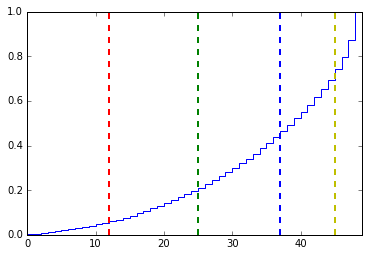

===========Source # 25==============
negative lobe
0.252873563218 21
75% of sources contribute 97.2677667749% of total flux
50% of sources contribute 89.090973119% of total flux
25% of sources contribute 69.8588596485% of total flux
10% of sources contribute 40.6311217329% of total flux


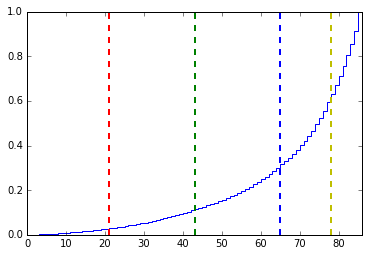

positive lobe
0.25641025641 39
75% of sources contribute 96.3999260667% of total flux
50% of sources contribute 86.7677051776% of total flux
25% of sources contribute 66.546098282% of total flux
10% of sources contribute 42.9066003252% of total flux


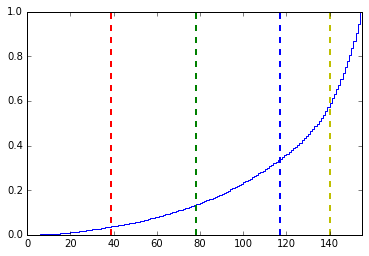

===========Source # 26==============
negative lobe
No values for mask DETECTED_NEGATIVE
positive lobe
0.255319148936 23
75% of sources contribute 94.0764381296% of total flux
50% of sources contribute 80.2296930139% of total flux
25% of sources contribute 54.3893943188% of total flux
10% of sources contribute 30.7500965887% of total flux


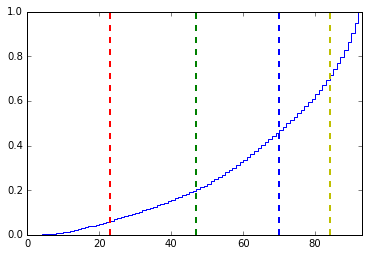

===========Source # 27==============
negative lobe
No values for mask DETECTED_NEGATIVE
positive lobe
0.253333333333 18
75% of sources contribute 96.8293587007% of total flux
50% of sources contribute 88.0203962863% of total flux
25% of sources contribute 68.9563648017% of total flux
10% of sources contribute 50.6676510549% of total flux


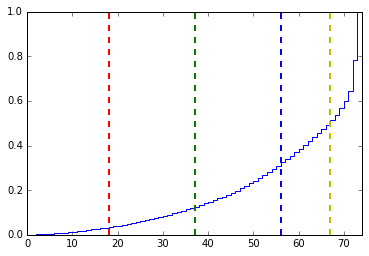

===========Source # 28==============
negative lobe
0.261538461538 16
75% of sources contribute 96.7617062191% of total flux
50% of sources contribute 87.127128873% of total flux
25% of sources contribute 64.2814592632% of total flux
10% of sources contribute 36.1507024569% of total flux


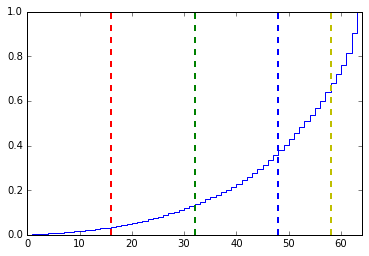

positive lobe
0.253968253968 47
75% of sources contribute 95.9858104045% of total flux
50% of sources contribute 86.5680754743% of total flux
25% of sources contribute 69.9053521104% of total flux
10% of sources contribute 43.1868137033% of total flux


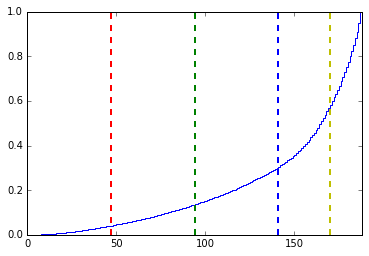

===========Source # 29==============
negative lobe
0.254545454545 13
75% of sources contribute 97.181639124% of total flux
50% of sources contribute 87.6630310824% of total flux
25% of sources contribute 67.2099984339% of total flux
10% of sources contribute 39.155378944% of total flux


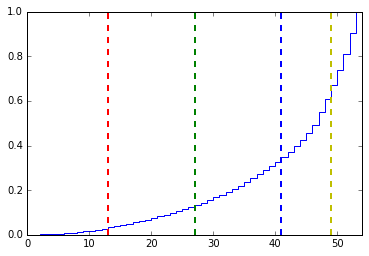

positive lobe
No values for mask DETECTED
===========Source # 30==============
negative lobe
0.263888888889 18
75% of sources contribute 96.9728807247% of total flux
50% of sources contribute 84.2823770383% of total flux
25% of sources contribute 59.9558802252% of total flux
10% of sources contribute 35.4255891007% of total flux


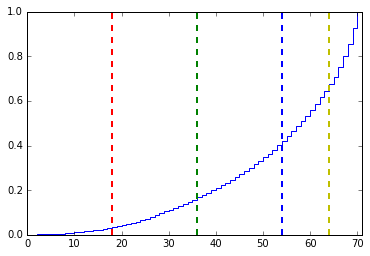

positive lobe
0.255319148936 23
75% of sources contribute 95.3465263534% of total flux
50% of sources contribute 81.8492729504% of total flux
25% of sources contribute 57.3125807608% of total flux
10% of sources contribute 30.9403510882% of total flux


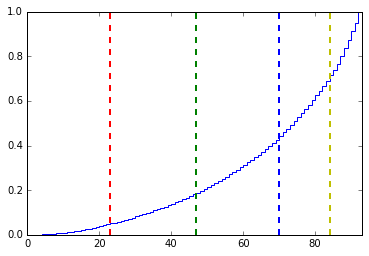

===========Source # 31==============
negative lobe
0.252336448598 26
75% of sources contribute 96.7689630276% of total flux
50% of sources contribute 86.3995679946% of total flux
25% of sources contribute 67.6353446706% of total flux
10% of sources contribute 45.5165427415% of total flux


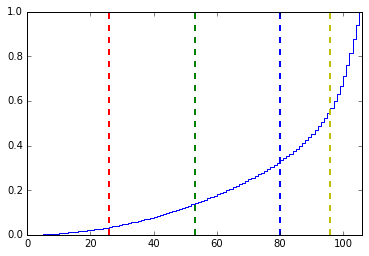

positive lobe
0.252577319588 48
75% of sources contribute 97.194691711% of total flux
50% of sources contribute 87.9275096005% of total flux
25% of sources contribute 68.7169014669% of total flux
10% of sources contribute 43.3343375115% of total flux


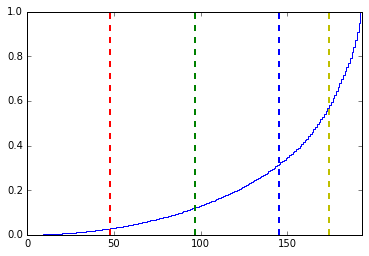

===========Source # 32==============
negative lobe
0.255555555556 22
75% of sources contribute 95.9033514278% of total flux
50% of sources contribute 83.9877945096% of total flux
25% of sources contribute 63.118425677% of total flux
10% of sources contribute 35.9619855913% of total flux


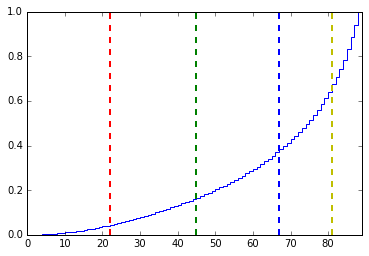

positive lobe
0.258333333333 30
75% of sources contribute 96.5057705203% of total flux
50% of sources contribute 86.581869108% of total flux
25% of sources contribute 67.3102227334% of total flux
10% of sources contribute 38.7347910319% of total flux


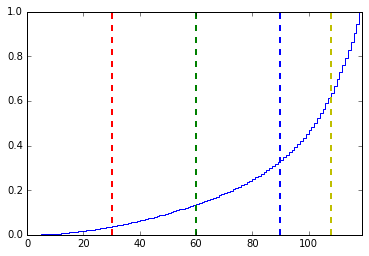

===========Source # 33==============
negative lobe
0.255813953488 21
75% of sources contribute 96.4694493444% of total flux
50% of sources contribute 84.8838778755% of total flux
25% of sources contribute 61.1754029259% of total flux
10% of sources contribute 36.4210173476% of total flux


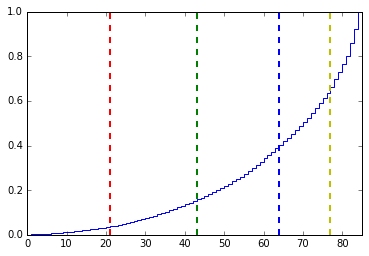

positive lobe
No values for mask DETECTED
===========Source # 34==============
negative lobe
0.251968503937 31
75% of sources contribute 98.3226199039% of total flux
50% of sources contribute 93.2494000376% of total flux
25% of sources contribute 78.7118221647% of total flux
10% of sources contribute 50.4591342365% of total flux


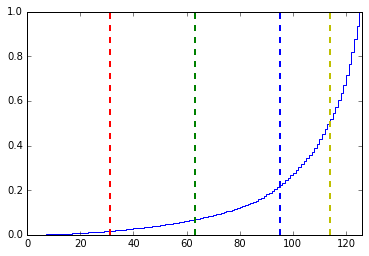

positive lobe
0.251046025105 59
75% of sources contribute 97.813800954% of total flux
50% of sources contribute 90.6703046664% of total flux
25% of sources contribute 76.5316884139% of total flux
10% of sources contribute 58.4908854218% of total flux


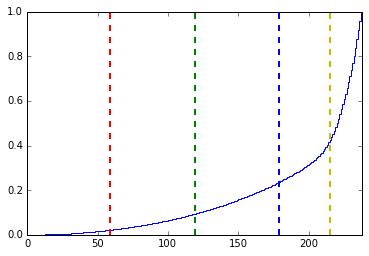

===========Source # 35==============
negative lobe
No values for mask DETECTED_NEGATIVE
positive lobe
0.254901960784 25
75% of sources contribute 96.0265482434% of total flux
50% of sources contribute 83.4537413945% of total flux
25% of sources contribute 63.8018295461% of total flux
10% of sources contribute 46.0904479661% of total flux


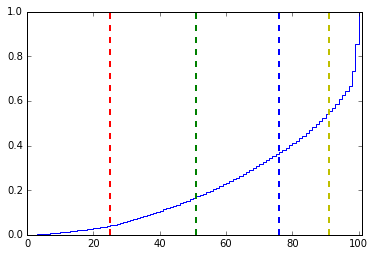

===========Source # 36==============

  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::afw::geom::Extent2I = lsst::afw::geom::Extent<int, 2>]
    Box2I(Point2I(256,4493),Extent2I(213,122)) doesn't fit in image 2048x4612 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(256,4493),Extent2I(213,122)) doesn't fit in image 2048x4612'



In [216]:
for i, s in enumerate(sources):
    try:
        print "===========Source # "+ str(i) +"=============="
        te_stamp = DSTools.get_stamp(s, diffExp)
        print "negative lobe"
        DSTools.plot_cumulative_flux(te_stamp, "DETECTED_NEGATIVE", positive=False)
        print "positive lobe"
        DSTools.plot_cumulative_flux(te_stamp, "DETECTED")
    except Exception, e:
        print e

In [63]:
ds9.mtv(sciExp, frame=6)

In [247]:
dipoles_pos = []
dipoles_neg = []
maybe_dipoles_pos = []
maybe_dipoles_neg = []
rejected_dipoles_pos = []
rejected_dipoles_neg = []
others_pos = []
others_neg = []
transients = []

In [248]:
for i, s in enumerate(sources):
    try:
        stamp = DSTools.get_stamp(s, diffExp)
        stamp_clone = stamp.clone()
        results = DSTools.detect_diasources(stamp_clone, doSmooth=True)
        negFps = len(results.fpSets.negative.getFootprints())
        posFps = len(results.fpSets.positive.getFootprints())
        pos_flux_at_25 = get_flux_percentage_at(stamp)
        neg_flux_at_25 = get_flux_percentage_at(stamp, plane_mask="DETECTED_NEGATIVE")
        
        if i == 22:            
            transients.append(pos_flux_at_25)
        elif negFps >0 and posFps>0:
            if DSTools.get_naive_dipole_probability(s) == 1.0:
                dipoles_pos.append(pos_flux_at_25)
                dipoles_neg.append(neg_flux_at_25)
            elif np.isnan(s.get("ip_diffim_PsfDipoleFlux_pos_flux")) or np.isnan(s.get("ip_diffim_PsfDipoleFlux_neg_flux")):
            
                maybe_dipoles_pos.append(pos_flux_at_25)
                maybe_dipoles_neg.append(neg_flux_at_25)
            else:
                rejected_dipoles_pos.append(pos_flux_at_25)
                rejected_dipoles_neg.append(neg_flux_at_25)
        else: 
            #print i
            #print "by default pos", pos_flux_at_25
            #print "by default neg", neg_flux_at_25
            if pos_flux_at_25 is not None:
                
                others_pos.append(pos_flux_at_25)
            else:
                
                others_neg.append(neg_flux_at_25)
                
        
    except Exception, e:
        print e


  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::afw::geom::Extent2I = lsst::afw::geom::Extent<int, 2>]
    Box2I(Point2I(983,0),Extent2I(1068,1091)) doesn't fit in image 2048x4612 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(983,0),Extent2I(1068,1091)) doesn't fit in image 2048x4612'


  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_vie

In [251]:
#print dipoles_pos
#print dipoles_neg
#print maybe_dipoles_pos
#print maybe_dipoles_neg
print rejected_dipoles_neg
print rejected_dipoles_pos
#print others_pos
#print others_neg
#print transients

[0.75704702326595186, 0.44976130505092249, 0.54094882636963215]
[0.69938521445806701, 0.92393264578836076, 0.9228633247795216]


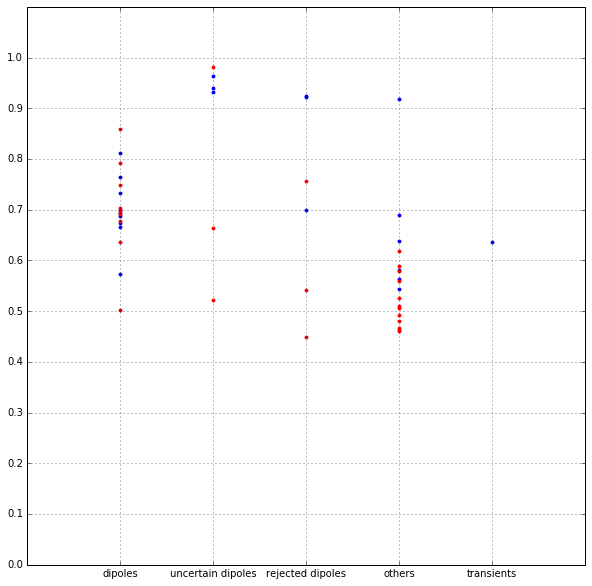

In [252]:
size = 15
p = 'b'
n = 'r'

plt.figure(figsize=(10,10))
plt.scatter([1 for val in dipoles_pos], dipoles_pos, s=size, c=p, lw=0)
plt.scatter([1 for val in dipoles_neg], dipoles_neg, s=size, c=n, lw=0)

plt.scatter([2 for val in maybe_dipoles_pos], maybe_dipoles_pos , s=size, c=p, lw=0)
plt.scatter([2 for val in maybe_dipoles_neg], maybe_dipoles_neg , s=size, c=n, lw=0)

plt.scatter([3 for val in rejected_dipoles_pos], rejected_dipoles_pos , s=size, c=p, lw=0)
plt.scatter([3 for val in rejected_dipoles_neg], rejected_dipoles_neg , s=size, c=n, lw=0)

plt.scatter([4 for val in others_pos], others_pos , s=size, c=p, lw=0)
plt.scatter([4 for val in others_neg], others_neg , s=size, c=n, lw=0)

plt.scatter([5 for val in transients], transients, s=size, lw=0)

plt.xticks([1,2,3,4, 5], ["dipoles", "uncertain dipoles", "rejected dipoles",  "others", "transients"])

plt.yticks(np.arange(0, 1.1, 0.1))

axes = plt.axes()
axes.grid(True)

plt.show()

In [199]:
def get_flux_percentage_at(stamp, percent = 0.25, plane_mask="DETECTED", positive=True):
    
    cumsum = DSTools.get_cumulative_flux(stamp, plane_mask=plane_mask, positive=positive)
    
    if cumsum is None:
        return None
    
    total = float(len(cumsum))
    
    for i, value in enumerate(cumsum):
        #print i, float(i+1)/total, 1-value
        if float(i+1)/total > (1-percent):
            return 1-value

0.57740730663
0.579036010867
0.254098360656 30
75% of sources contribute 95.1357749525% of total flux
50% of sources contribute 81.697957735% of total flux
25% of sources contribute 57.740730663% of total flux
10% of sources contribute 33.526750733% of total flux


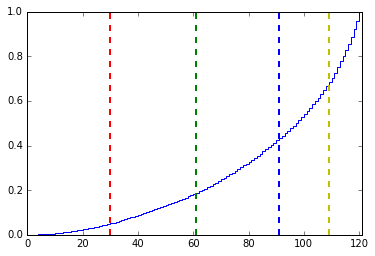

array([  8.11916301e-05,   3.46057864e-04,   6.11998594e-04,
         9.03598923e-04,   1.31477299e-03,   1.78132367e-03,
         2.28734203e-03,   2.84897760e-03,   3.42594478e-03,
         4.36965178e-03,   5.35117462e-03,   6.56480451e-03,
         7.82710745e-03,   9.21037936e-03,   1.07633895e-02,
         1.23917748e-02,   1.41262143e-02,   1.59426524e-02,
         1.78478085e-02,   1.98405760e-02,   2.19008765e-02,
         2.41259597e-02,   2.66040946e-02,   2.91646610e-02,
         3.17986139e-02,   3.44353733e-02,   3.71311978e-02,
         3.98530028e-02,   4.27240503e-02,   4.56637694e-02,
         4.86422505e-02,   5.17290632e-02,   5.50544941e-02,
         5.85384533e-02,   6.22833546e-02,   6.60792863e-02,
         6.99805347e-02,   7.38895291e-02,   7.78133580e-02,
         8.17837269e-02,   8.58365113e-02,   8.99116516e-02,
         9.39983708e-02,   9.81009348e-02,   1.02211052e-01,
         1.06358922e-01,   1.10652617e-01,   1.14972438e-01,
         1.19422706e-01,

In [217]:
stamp = DSTools.get_stamp(sources[8], diffExp)
print get_flux_percentage_at(stamp, percent=0.25, plane_mask="DETECTED_NEGATIVE", positive=False)
print get_flux_percentage_at(stamp, percent=0.25, plane_mask="DETECTED_NEGATIVE", positive=True)
DSTools.plot_cumulative_flux(stamp, "DETECTED_NEGATIVE", positive=False)